# Notebook Setup

This cell sets the project root path and ensures that it is added to `sys.path` so that local modules (e.g., those in the `src` folder) can be imported.

In [92]:
# run once per notebook
import sys, pathlib, importlib
ROOT = pathlib.Path.cwd().parents[0]      # …/RL-Pairs-Trading-Replication
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))
print("ROOT on path →", ROOT)


ROOT on path → /Users/freddieliang/Desktop/RL-Pairs-Trading-Replication


# Import and Run Spread Generation Script

This cell imports `src.make_spread` which automatically executes the spread-generation logic to build or update the file `data/test_spread.csv`. The `importlib.reload` call ensures that any recent changes to the script are picked up.

In [93]:
import importlib
import src.make_spread         # executes on import, builds data/test_spread.csv
importlib.reload(src.make_spread)  # run again if you edit the script

/Users/freddieliang/Desktop/RL-Pairs-Trading-Replication/src/make_spread.py:42: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .sort_index()


Wrote 131,101 rows   window=900   clipped=[-25233.2, 54930.7]
→ data/test_spread.csv


<module 'src.make_spread' from '/Users/freddieliang/Desktop/RL-Pairs-Trading-Replication/src/make_spread.py'>

# Load and Visualize the Residual Spread

In this cell we load the generated spread data from `data/test_spread.csv` and then plot the residual spread over time to visualize its behavior.

In [94]:
# === Cell: Load and Split Data ===
import pandas as pd

# Load the data, using 'timestamp' column as index and parsing dates
try:
    spread_df = pd.read_csv("../data/test_spread.csv", index_col='timestamp', parse_dates=True)
    spread = spread_df['spread'] # Get the spread Series
    print(f"Loaded spread data with {len(spread)} rows.")
    print(f"Index type: {type(spread.index)}")

    # Split into 80% train and 20% test (using .iloc preserves the index)
    train_size = int(len(spread) * 0.8)
    spread_train = spread.iloc[:train_size]
    spread_test = spread.iloc[train_size:]

    print(f"Train size: {len(spread_train)}, Test size: {len(spread_test)}")
    print(f"Test data index type: {type(spread_test.index)}")
    print(f"First 5 test index values: {spread_test.index[:5]}")

except FileNotFoundError:
    print("Error: ../data/test_spread.csv not found. Make sure make_spread.py ran correctly.")
except Exception as e:
    print(f"Error loading data: {e}")

Loaded spread data with 131101 rows.
Index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Train size: 104880, Test size: 26221
Test data index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
First 5 test index values: DatetimeIndex(['2023-12-13 03:00:00+00:00', '2023-12-13 03:01:00+00:00',
               '2023-12-13 03:02:00+00:00', '2023-12-13 03:03:00+00:00',
               '2023-12-13 03:04:00+00:00'],
              dtype='datetime64[ns, UTC]', name='timestamp', freq=None)


# Test the Residual Spread for Stationarity

This cell uses the Augmented Dickey-Fuller test from `statsmodels` to check whether the residual spread is stationary (a p-value < 0.05 indicates stationarity).

In [95]:
from statsmodels.tsa.stattools import adfuller
print(adfuller(spread.dropna())[1])   # p-value < 0.05 ⇒ stationary

4.704724455989033e-20


In [96]:
import pandas as pd

# Load the full spread
spread_df = pd.read_csv("../data/test_spread.csv", index_col='timestamp', parse_dates=True)
spread = spread_df['spread'] # Get the spread Series

# Split into 80% train and 20% test
train_size = int(len(spread) * 0.8)
spread_train = spread.iloc[:train_size] # Index is preserved
test_spread = spread.iloc[train_size:]  # Index is preserved

# Setup RL Environment and Train the Model

This cell performs several tasks:
- Imports RL algorithms (A2C, PPO) from Stable-Baselines3 and the custom environment `PairTradingEnv` from `src.rl_environment.py`.
- Loads the spread data.
- Sets the RL variant (`RL1` for discrete actions or `RL2` for continuous).
- Creates the trading environment with parameters (window, thresholds, fee, etc.).
- Chooses the algorithm (A2C for RL1, PPO for RL2).
- Trains the model for 100,000 timesteps.
- Saves the trained model to disk.

In [98]:
# Ensure the spread is split correctly
import pandas as pd
spread = pd.read_csv("../data/test_spread.csv")["spread"]
train_size = int(len(spread) * 0.8)
spread_train = spread.iloc[:train_size].reset_index(drop=True)
test_spread = spread.iloc[train_size:].reset_index(drop=True)

from stable_baselines3 import A2C, PPO
from src.rl_environment import PairTradingEnv # Make sure this is imported

RL_VARIANT = "RL1"  # or use "RL2" if you have continuous actions
env_train = PairTradingEnv(
    spread=spread_train.reset_index(drop=True),
    rl_mode=RL_VARIANT,
    window=900,
    open_thr=1.8,
    close_thr=0.4,
    fee=0.0002,
)
ALG = A2C if RL_VARIANT == "RL1" else PPO
model = ALG("MlpPolicy", env_train, verbose=1, tensorboard_log="logs/")
print(f"Training {RL_VARIANT} model...")
model.learn(total_timesteps=100_000) # Or your desired timesteps
model_path = f"models/pair_trading_{RL_VARIANT.lower()}" # Save to a 'models' subfolder
model.save(model_path)
print(f"Model saved to {model_path}")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Training RL1 model...
Logging to logs/A2C_8


/opt/anaconda3/envs/rlpairs/lib/python3.9/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


------------------------------------
| time/                 |          |
|    fps                | 1487     |
|    iterations         | 100      |
|    time_elapsed       | 0        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -0.97    |
|    explained_variance | -0.0395  |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 8.82     |
|    value_loss         | 180      |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 1507     |
|    iterations         | 200      |
|    time_elapsed       | 0        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -0.479   |
|    explained_variance | 0.000841 |
|    learning_rate      | 0.0007   |
|    n_updates          | 199      |
|    policy_loss        | -10.6    |
|    value_loss         | 5.05e+03 |
-

/opt/anaconda3/envs/rlpairs/lib/python3.9/site-packages/stable_baselines3/common/save_util.py:284: UserWarning: Path 'models' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


# Full Dataset Backtesting

This cell loads the saved model and creates a test environment instance. It then runs the trained model on the full dataset to simulate trading, accumulating total P&L and printing the final result.

In [99]:
# Use a separate test environment for evaluation
env_test = PairTradingEnv(test_spread, rl_mode=RL_VARIANT)
model = ALG.load(model_path, env=env_test)
obs, done, pnl = env_test.reset(), False, 0.0
while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, _ = env_test.step(action)
    pnl += reward
print(f"Total P&L on test dataset: {pnl:,.2f}")

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Total P&L on test dataset: 377,657.17


# Backtest on the Last 1,000 Bars and Plot Equity Curve

Here we create a test environment for only the final 1,000 data points. The cell proceeds to simulate trading, records the equity curve (cumulative P&L over time), and finally plots the equity curve for visual inspection.

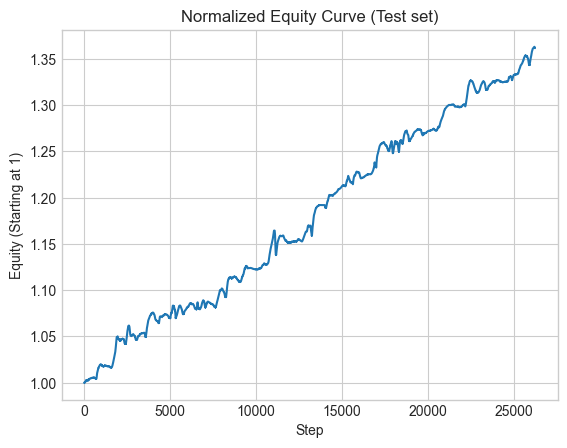

In [ ]:
import matplotlib.pyplot as plt
import numpy as np # Make sure numpy is imported

# Run simulation to record cumulative P&L (equity curve) on the test set
env_test_curve = PairTradingEnv(test_spread, rl_mode=RL_VARIANT)
obs = env_test_curve.reset()

initial_portfolio_value = 1000000 # Or whatever your assumed starting capital is
portfolio_value = [initial_portfolio_value]
rewards_log = [] # Optional: log rewards to debug

while True:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, info = env_test_curve.step(action)
    rewards_log.append(reward) # Optional debugging

    # Calculate the new portfolio value by adding the absolute reward
    # NOTE: This assumes 'reward' IS the absolute P&L for the step.
    # If not, you might need to scale it or use info dict if it provides P&L.
    current_value = portfolio_value[-1] + reward
    portfolio_value.append(current_value)

    if done:
        break

# Now portfolio_value contains the actual equity curve (unnormalized)
# Normalize it by dividing by the starting value
equity_rl_normalized = np.array(portfolio_value) / initial_portfolio_value

# Plot the NORMALIZED curve
plt.plot(equity_rl_normalized)
plt.title("Normalized Equity Curve (Test set)")
plt.xlabel("Step")
plt.ylabel("Equity (Starting at 1)")
plt.show()

# Sanity Checks

--- Running Cumulative Returns Plot Cell (Using Existing Variables) ---
Aligned equity curve and dates. Plotting 26220 points.


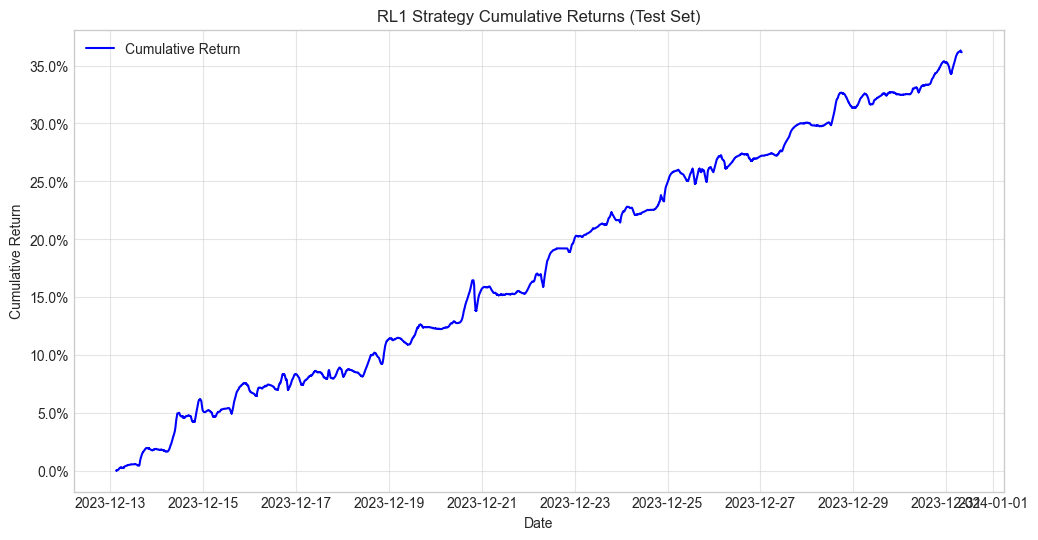

--- Finished Cumulative Returns Plot Cell ---


In [ ]:
# === New Cell for Cumulative Returns Plot ===
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import PercentFormatter # Import PercentFormatter

# --- Ensure equity_rl_normalized and spread_test are available from previous cells ---
# Assuming 'equity_rl_normalized' (from cell 106) and
# 'spread_test' (the Series/DataFrame with the DatetimeIndex from cell 94/96)
# are loaded and available in the notebook's environment.

print("--- Running Cumulative Returns Plot Cell (Using Existing Variables) ---")

try:
    # --- 1. Align Data (using logic from your drawdown code) ---
    # Create a pandas Series for the normalized equity curve, starting from the second point (value after step 1)
    # Align it with the corresponding dates from the test set index
    # Ensure correct slicing to match lengths
    num_equity_points = len(equity_rl_normalized)
    if num_equity_points -1 > len(spread_test.index):
        print(f"Warning: Equity curve length ({num_equity_points}) seems too long for test index ({len(spread_test.index)}). Trimming equity curve.")
        equity_curve_values = equity_rl_normalized[1:len(spread_test.index)+1]
        aligned_dates = spread_test.index
    elif num_equity_points - 1 < len(spread_test.index):
         print(f"Warning: Equity curve length ({num_equity_points}) seems too short for test index ({len(spread_test.index)}). Trimming test index.")
         equity_curve_values = equity_rl_normalized[1:]
         aligned_dates = spread_test.index[:num_equity_points-1]
    else:
        equity_curve_values = equity_rl_normalized[1:]
        aligned_dates = spread_test.index

    # Check if alignment resulted in data to plot
    if len(equity_curve_values) == 0:
         print("Error: No data points remain after alignment.")
    else:
        equity_curve_dated = pd.Series(equity_curve_values, index=aligned_dates)
        print(f"Aligned equity curve and dates. Plotting {len(equity_curve_dated)} points.")

        # --- 2. Calculate Cumulative Returns ---
        # Since equity_curve_dated is normalized equity starting from 1, subtract 1 for cumulative return
        cumulative_returns = equity_curve_dated - 1

        # --- 3. Plot Cumulative Returns ---
        plt.figure(figsize=(12, 6))
        plt.plot(cumulative_returns.index, cumulative_returns, label='Cumulative Return', color='blue') # Changed color
        # Removed fill_between as it's more suitable for drawdown

        plt.title('RL1 Strategy Cumulative Returns (Test Set)') # Updated title
        plt.xlabel('Date')
        plt.ylabel('Cumulative Return') # Updated label

        # Format Y-axis as percentage
        plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1.0))

        plt.grid(True, alpha=0.5)
        plt.legend()
        plt.show()

except NameError as e:
    print(f"Error: A required variable (e.g., 'equity_rl_normalized' or 'spread_test') is not defined.")
    print("Please ensure the cells that define these variables have been run.")
    print(f"(Specific error: {e})")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

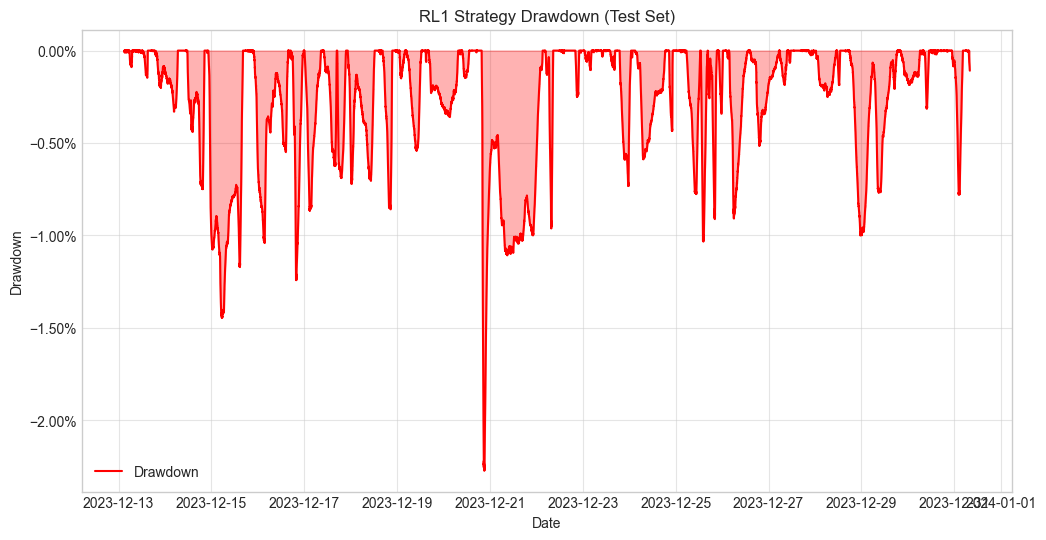

In [119]:
# filepath: /Users/freddieliang/Desktop/RL-Pairs-Trading-Replication/notebooks/RL.ipynb
# --- New Cell for Drawdown Plot ---
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Ensure equity_rl_normalized and spread_test are available from previous cells

# Calculate Drawdown
# Use the equity curve starting from the second point to align with dates
equity_curve_for_drawdown = pd.Series(equity_rl_normalized[1:], index=spread_test.index[:len(equity_rl_normalized)-1])
running_max = equity_curve_for_drawdown.cummax()
drawdown = (equity_curve_for_drawdown / running_max) - 1

# Plot Drawdown
plt.figure(figsize=(12, 6))
plt.plot(drawdown.index, drawdown, label='Drawdown', color='red')
plt.fill_between(drawdown.index, drawdown, 0, color='red', alpha=0.3)
plt.title('RL1 Strategy Drawdown (Test Set)')
plt.xlabel('Date')
plt.ylabel('Drawdown')
from matplotlib.ticker import PercentFormatter
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1.0))
plt.grid(True, alpha=0.5)
plt.legend()
plt.show()

In [120]:
# Sanity Checks
import numpy as np

# Use the normalized equity curve calculated in the previous cell
returns = np.diff(equity_rl_normalized)                    # 1-step P&L change based on normalized equity
# Adjust Sharpe calculation if needed based on normalized returns
# Assuming returns are now fractional changes (e.g., 0.01 for 1%)
# The Sharpe calculation might need adjustment depending on the exact nature of 'returns'
# If returns = np.diff(equity_rl_normalized) represents the change in the normalized value (e.g., 1.01 - 1.00 = 0.01),
# then the Sharpe ratio calculation might be okay as is, but verify the interpretation.
sharpe  = returns.mean() / returns.std() * np.sqrt(60)  # 60 bars ≈ 1h (Adjust sqrt factor if data frequency differs)

print(f"Mean step P&L (Normalized Change): {returns.mean():.4f}") # Adjusted label
print(f"Sharpe (per-hour proxy): {sharpe:.2f}")

# Calculate drawdown based on the normalized equity curve
max_drawdown_normalized = np.min(equity_rl_normalized / np.maximum.accumulate(equity_rl_normalized) - 1)
print(f"Max drawdown (Normalized): {max_drawdown_normalized:.2%}") # Display as percentage

# ...rest of the notebook...

Mean step P&L (Normalized Change): 0.0000
Sharpe (per-hour proxy): 1.47
Max drawdown (Normalized): -2.27%


--- Running Styled Daily Returns Plot Cell ---
Aligned equity curve and dates. Processing 26220 points.
Calculated 18 daily return points.


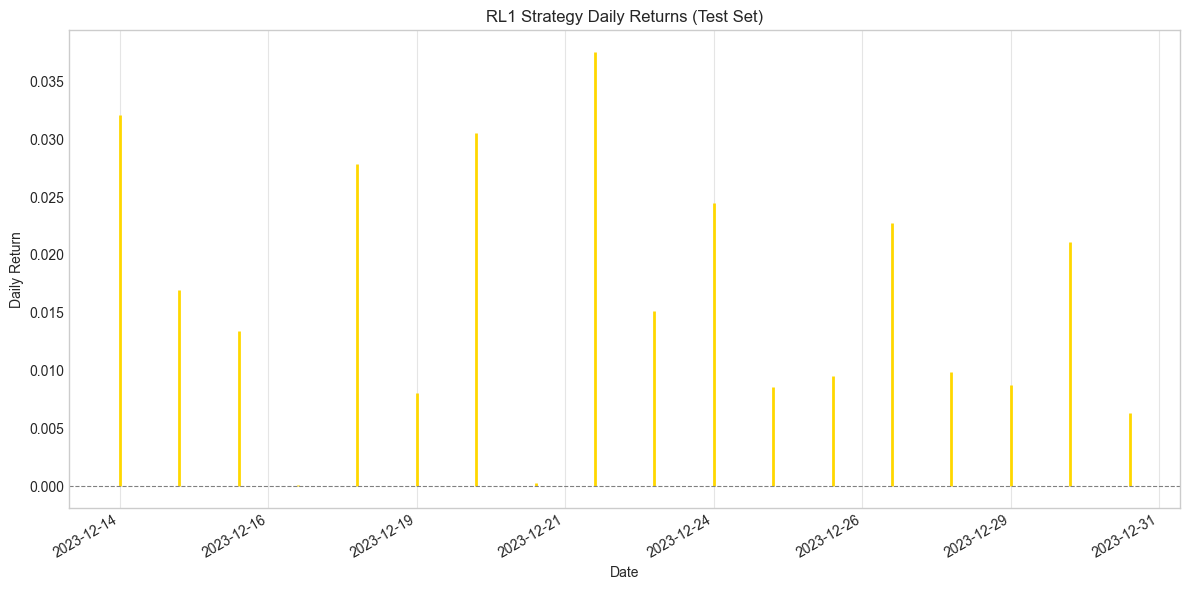

--- Finished Styled Daily Returns Plot Cell ---


In [124]:
# === New Cell: Daily Returns Plot (Styled) ===
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
# NOTE: Removed PercentFormatter as the example doesn't use it

# --- Ensure equity_rl_normalized and spread_test are available ---
# Assuming 'equity_rl_normalized' and 'spread_test' (with DatetimeIndex)
# are available from previous cells.

print("--- Running Styled Daily Returns Plot Cell ---")

try:
    # --- 1. Align Data ---
    num_equity_points = len(equity_rl_normalized)
    if num_equity_points - 1 > len(spread_test.index):
        equity_curve_values = equity_rl_normalized[1:len(spread_test.index)+1]
        aligned_dates = spread_test.index
    elif num_equity_points - 1 < len(spread_test.index):
         equity_curve_values = equity_rl_normalized[1:]
         aligned_dates = spread_test.index[:num_equity_points-1]
    else:
        equity_curve_values = equity_rl_normalized[1:]
        aligned_dates = spread_test.index

    if len(equity_curve_values) == 0:
         print("Error: No data points remain after alignment.")
    else:
        equity_curve_dated = pd.Series(equity_curve_values, index=aligned_dates)
        print(f"Aligned equity curve and dates. Processing {len(equity_curve_dated)} points.")

        # --- 2. Calculate Daily Returns ---
        equity_daily = equity_curve_dated.resample('D').last()
        daily_returns = equity_daily.pct_change().dropna() # Still need daily % change

        print(f"Calculated {len(daily_returns)} daily return points.")

        # --- 3. Plot Daily Returns (Styled) ---
        if len(daily_returns) > 0:
            # Apply a style similar to the example (adjust 'ggplot' if needed)
            # 'seaborn-v0_8-whitegrid' is another option for white grid
            # plt.style.use('ggplot') # ggplot style often has grey background + white grid

            fig, ax = plt.subplots(figsize=(12, 6))

            # Define colors
            positive_color = 'gold' # Yellow/gold like the example
            negative_color = 'mediumpurple' # Purple/red for negative (adjust as needed)

            # Create masks for positive and negative returns
            positive_mask = daily_returns >= 0
            negative_mask = daily_returns < 0

            # Plot vertical lines using vlines
            ax.vlines(daily_returns.index[positive_mask], 0, daily_returns[positive_mask],
                      color=positive_color, linewidth=2, label='Positive Return')
            ax.vlines(daily_returns.index[negative_mask], 0, daily_returns[negative_mask],
                      color=negative_color, linewidth=2, label='Negative Return')

            # Add horizontal line at zero
            ax.axhline(0, color='grey', linestyle='--', linewidth=0.8)

            ax.set_title('RL1 Strategy Daily Returns (Test Set)')
            ax.set_xlabel('Date')
            ax.set_ylabel('Daily Return') # Label without percentage

            # Grid lines (vertical only like example)
            ax.xaxis.grid(True, linestyle='-', alpha=0.5) # Vertical grid lines
            ax.yaxis.grid(False) # Turn off horizontal grid lines

            # Format X-axis dates
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) # Format like example
            ax.xaxis.set_major_locator(plt.MaxNLocator(8)) # Adjust number of date ticks shown
            plt.xticks(rotation=30, ha='right') # Rotate dates like example

            # Optional: Set background color if style doesn't handle it
            # ax.set_facecolor('#f0f0f0') # Light grey background

            # Optional: Customize spines if needed
            # ax.spines['top'].set_visible(False)
            # ax.spines['right'].set_visible(False)

            # Create a combined legend (optional, as colors are distinct)
            # handles, labels = ax.get_legend_handles_labels()
            # ax.legend(handles, labels) # May show duplicate labels, handle if needed

            plt.tight_layout()
            plt.show()

            # Reset style to default if you don't want it affecting subsequent plots
            # plt.style.use('default')

        else:
            print("No daily returns calculated.")

except NameError as e:
    print(f"Error: A required variable (e.g., 'equity_rl_normalized' or 'spread_test') is not defined.")
    print(f"(Specific error: {e})")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

print("--- Finished Styled Daily Returns Plot Cell ---")